### Data Ingestion

In [242]:
# How to read the data files in Python

import pandas as pd
users = pd.read_csv("users.csv")
user_engagement = pd.read_csv("engagement.csv")

### 1) Calculating Adoption Rate

In [243]:
user_engagement.shape

(207917, 3)

#### **Preprocess User Engagement DataFrame**

First sort by user_id's and the time_stamp when they logged in, removing any duplicates.

In [244]:
# Convert time_stamp to datetime
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
# Round time_stamp to the nearest day
user_engagement['time_stamp'] = user_engagement['time_stamp'].dt.floor('d')

# Sort dataframe by user_id and time_stamp
user_engagement = user_engagement.sort_values(by=['user_id', 'time_stamp']).drop_duplicates()
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


#### **Use Rolling Window to Calculate Adoption Rate**

Now that we have a sorted, unique DataFrame, we will apply a 7-day rolling window to each user's login dates. If there are at least three unique days within the window where the user logged in, they will be classified as an adopted user.

In [245]:
# Apply a rolling window to count the number of logins, if greater then 3, the user is a adopted user
def is_adopted_user(user_dates):
    user_dates = user_dates.reset_index(drop=True)
    user_dates.index = user_dates
    return user_dates.rolling('7D').count().max() >= 3

adopted_users = user_engagement.groupby('user_id')['time_stamp'].apply(is_adopted_user).reset_index()

In [246]:
# Create a new column in users dataframe to indicate if the user is an adopted user
users['is_adopted_user'] = users['object_id'].isin(adopted_users[adopted_users['time_stamp'] == True]['user_id']).astype(int)

#### **Sanity Checks**

In [247]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,is_adopted_user
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com,0
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com,1
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com,0
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com,0
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com,0


In [248]:
users['is_adopted_user'].value_counts()

is_adopted_user
0    10398
1     1602
Name: count, dtype: int64

### 2) Methodology

#### **Preliminary Cleaning**

In [249]:
# Convert last session creation time to Datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [250]:
# Find number of duplicates
duplicate_name_and_email = users.drop_duplicates(['email', 'name'], keep='first')
duplicate_name_email_and_orgid = users.drop_duplicates(['email', 'name', 'org_id'], keep='first')
print('Number of duplicates in name and email:', users.shape[0] - duplicate_name_and_email.shape[0])
print('Number of duplicates in name, email and org_id:', users.shape[0] - duplicate_name_email_and_orgid.shape[0])

Number of duplicates in name and email: 19
Number of duplicates in name, email and org_id: 0


There are a few users that are a part of multiple organizations, this could play a factor in adoption rate.

#### **Preliminary Feature Selection**

Let's begin feature selection by considering which features make intuitive sense to include. Below are all the features in the users DataFrame and the reasons why they should be explored or excluded in the future feature selection methodology:

1. <font color='Salmon'>object_id</font> - Exclude: Since object_ids are unique, they are unlikely to have an effect on the adoption rate.
2. <font color='PaleGreen'>creation_time</font> - Explore: Should consider the seasonality bias associated with when a user creates an account.
3. <font color='Salmon'>name</font> - Exclude: It is unlikely that names will affect the adoption rate.
4. <font color='Salmon'>email</font> - Exclude: Since email_domain is being explored and the only difference is the username at the beginning of the email, it is unlikely to affect the adoption rate.
5. <font color='PaleGreen'>creation_source</font> - Explore: Some sources may have higher adoption rates.
6. <font color='PaleGreen'>last_session_creation_time</font> - Explore: Captures a snapshot of user behavior.
7. <font color='PaleGreen'>opted_in_to_mailing_list</font> - Explore: Should consider whether being on the mailing list affects the adoption rate.
8. <font color='PaleGreen'>enabled_for_marketing_drip</font> - Explore: Should consider whether being on the marketing email drip affects the adoption rate.
9. <font color='PaleGreen'>org_id</font> - Explore: Should consider if the organization they are associated with affects the adoption rate.
10. <font color='PaleGreen'>invited_by_user_id</font> - Explore: Should consider whether users who were invited have a higher adoption rate.
11. <font color='PaleGreen'>email_domain</font> - Explore: Certain domains may have higher adoption rates than others.

#### **Exploratory Data Analysis**

In [251]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted_user
count,12000.00000,8823,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,2013-09-15 21:08:25.700441856,0.249500,0.149333,141.884583,5962.957145,0.133500
min,1.00000,2012-05-31 08:20:06,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,2013-03-13 17:16:05,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6000.50000,2013-10-27 15:41:10,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9000.25000,2014-04-25 16:16:44,0.000000,0.000000,238.250000,8817.000000,0.000000
max,12000.00000,2014-06-06 14:58:50,1.000000,1.000000,416.000000,11999.000000,1.000000
std,3464.24595,NaN,0.432742,0.356432,124.056723,3383.761968,0.340128


In [252]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Create seperate adopted and non adopted users dataframes
adopted_users = users[users['is_adopted_user'] == 1]
non_adopted_users = users[users['is_adopted_user'] == 0]

*Compare Email Domains between all users, adopted users and non adopted users*

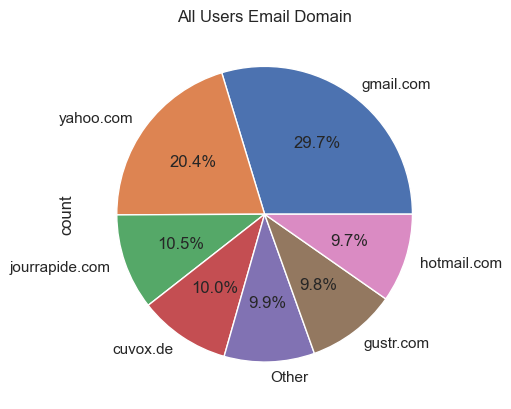

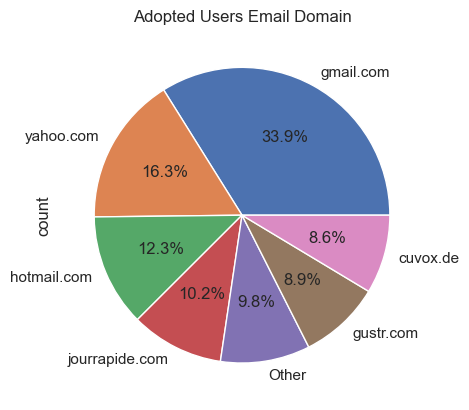

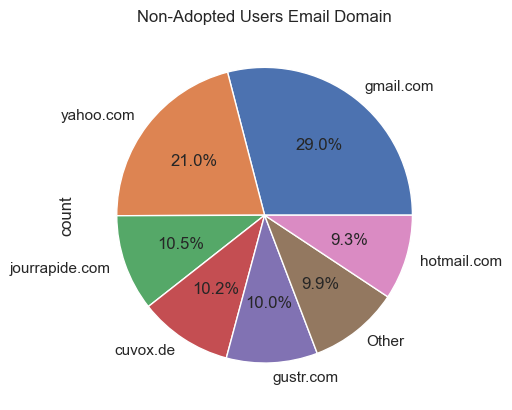

In [262]:
# Aggregate all emails that do not have atleast 10 users into 'Other'
domain_counts = users['email_domain'].value_counts()
domains_to_keep = domain_counts[domain_counts > 10].index
users.loc[:, 'email_domain_eda'] = users['email_domain'].apply(lambda x: x if x in domains_to_keep else 'Other')
adopted_users.loc[:, 'email_domain_eda'] = adopted_users['email_domain'].apply(lambda x: x if x in domains_to_keep else 'Other')
non_adopted_users.loc[:, 'email_domain_eda'] = non_adopted_users['email_domain'].apply(lambda x: x if x in domains_to_keep else 'Other')

# Overall pie chart of creation_source
users['email_domain_eda'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("All Users Email Domain")
plt.show()

# Pie chart of creation_source for adopted users
adopted_users['email_domain_eda'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Adopted Users Email Domain")
plt.show()

# Pie chart of creation_source for non-adopted users
non_adopted_users['email_domain_eda'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Non-Adopted Users Email Domain")
plt.show()

It appears that users with a gmail.com and hotmail.com domains are more likely to be adopted users.

*Compare Creation Source between all users, adopted users and non adopted users*

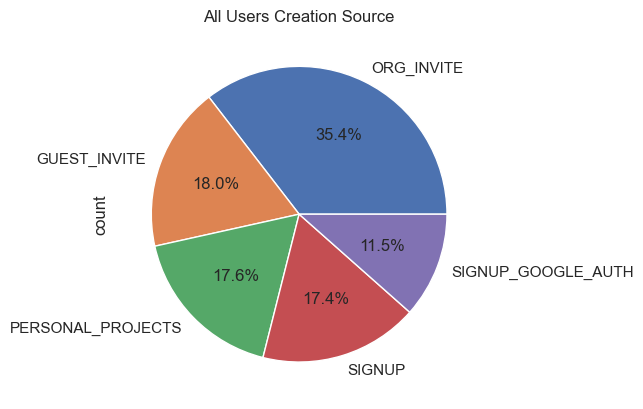

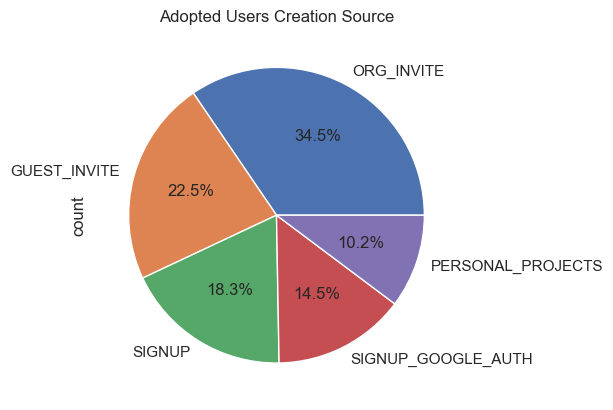

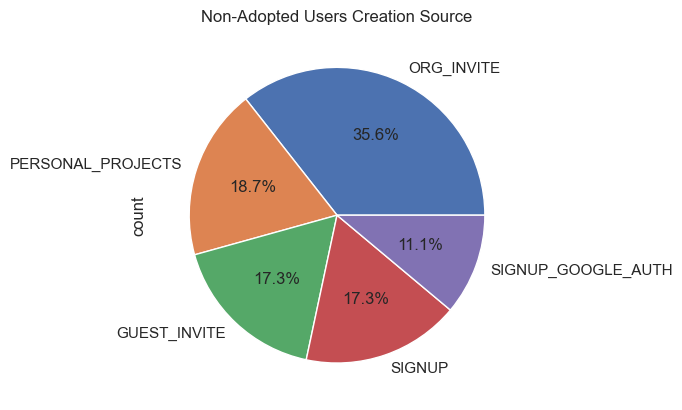

In [254]:
# Overall pie chart of creation_source
users['creation_source'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("All Users Creation Source")
plt.show()

# Pie chart of creation_source for adopted users
adopted_users['creation_source'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Adopted Users Creation Source")
plt.show()

# Pie chart of creation_source for non-adopted users
non_adopted_users['creation_source'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Non-Adopted Users Creation Source")
plt.show()

It appears that users that are invited via guest_invite and sign up are more likely to be adopted users. While users who created their account via personal projects and signup_google_auth are more likely to not be adopted users. 

*Compare Opted into Mailing List between all users, adopted users and non adopted users*

In [255]:
print("Percent Opted in to Mailing List for All Users: ", users['opted_in_to_mailing_list'].mean())
print("Percent Opted in to Mailing List for Adopted Users: ", adopted_users['opted_in_to_mailing_list'].mean())
print("Percent Opted in to Mailing List for Non-Adopted Users: ", non_adopted_users['opted_in_to_mailing_list'].mean())

Percent Opted in to Mailing List for All Users:  0.2495
Percent Opted in to Mailing List for Adopted Users:  0.25842696629213485
Percent Opted in to Mailing List for Non-Adopted Users:  0.24812463935372187


It appears that users who have opted into the mailing list are more likely to be adopted users. This could be due to the fact that users who are more engaged with the platform are more likely to opt into the mailing list. This could be a potential feature to include in a model to predict adopted users.

*Compare Enabled Marketing Drip between all users, adopted users and non adopted users*

In [256]:
print("Percent Enabled for Marketing Drip for All Users: ", users['enabled_for_marketing_drip'].mean())
print("Percent Enabled for Marketing Drip for Adopted Users: ", adopted_users['enabled_for_marketing_drip'].mean())
print("Percent Enabled for Marketing Drip for Non-Adopted Users: ", non_adopted_users['enabled_for_marketing_drip'].mean())

Percent Enabled for Marketing Drip for All Users:  0.14933333333333335
Percent Enabled for Marketing Drip for Adopted Users:  0.15355805243445692
Percent Enabled for Marketing Drip for Non-Adopted Users:  0.14868243893056357


It appears that users who have enabled the marketing drip are more likely to be adopted users. This could be due to the fact that users who are more engaged with the product are more likely to enable the marketing drip.

#### **Feature Engineering**

1. Year and Month of Account Creation
2. Column for whether user was invited by another user or not
3. Size of Organization

In [307]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['creation_year'] = users['creation_time'].dt.year
users['creation_month'] = users['creation_time'].dt.month
users['was_invited'] = users['invited_by_user_id'].notnull().astype(int)
users['org_size'] = users['org_id'].map(users['org_id'].value_counts())
users['last_session_creation_time'] = users['last_session_creation_time'].astype(int) / 1e9

#### **Correlation Analysis**

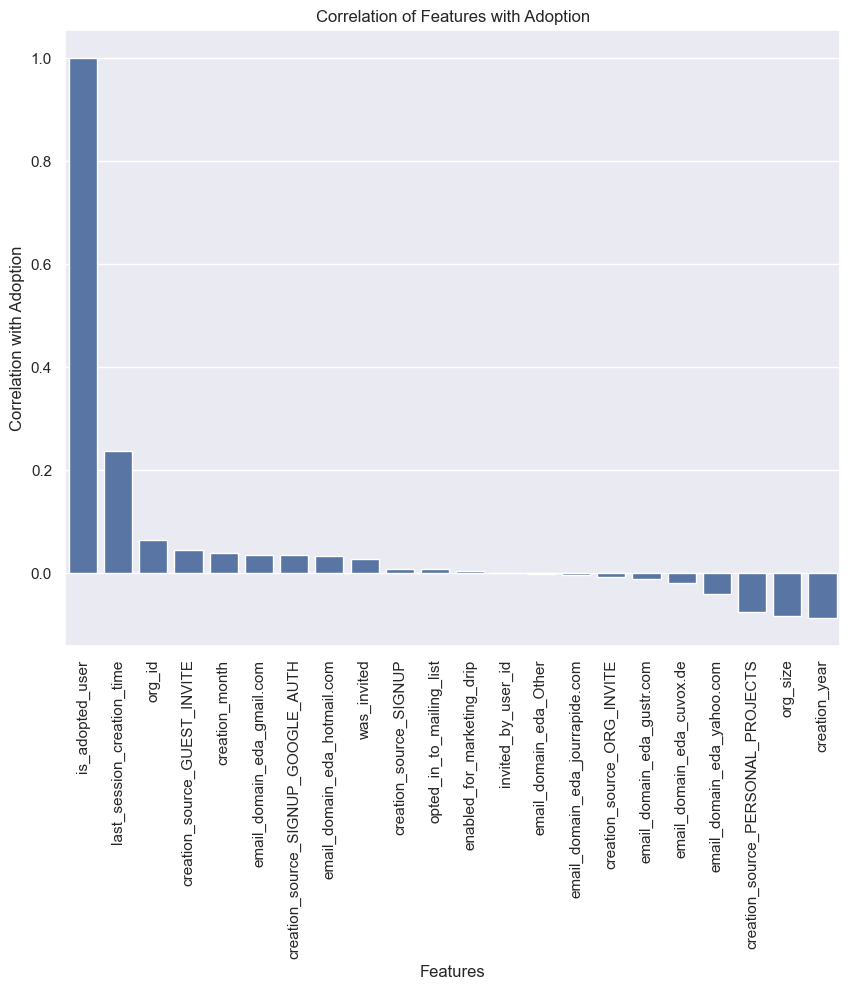

In [308]:
# Convert categorical variables to dummy variables
users_encoded = users[['opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id','email_domain_eda', 'creation_source', 'is_adopted_user', 'creation_year', 'creation_month', 'was_invited', 'org_size','last_session_creation_time']].copy()
users_encoded = pd.get_dummies(users_encoded, columns=['creation_source', 'email_domain_eda'])

correlation_matrix = users_encoded.corr()

# Extract correlation with 'is_adopted_user'
adoption_corr = correlation_matrix['is_adopted_user'].sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=adoption_corr.index, y=adoption_corr.values)
plt.title('Correlation of Features with Adoption')
plt.xlabel('Features')
plt.ylabel('Correlation with Adoption')
plt.xticks(rotation=90)
plt.show()


##### 2a) Writeup associated with methodology

To best determine the important features needed to predict user adoption, it is crucial to consider both mathematically significant features and those that logically make sense. For instance, in the case of user adoption, the month a user joined alone may not be a strong enough indicator. However, when paired with other features like creation source, it can help more deeply capture the adoption behavior of users. Below is an analysis conducted to help determine the ideal feature set for predicting user adoption and to better inform decision-making.

1. **Preliminary Feature Selection:**

    This feature selection technique involves using logical reasoning to identify relevant features. Through this analysis, it was concluded that features like name, object_id, and email are likely not useful. Specifically, these features do not have a direct impact on a user's behavior or interaction with the product. The name and email are unique identifiers that do not influence how a user engages with the product, while object_id is simply a unique ID for each user. On the other hand, features like creation_source, opted_in_to_mailing_list, last_session_creation_time, and enabled_for_marketing_drip are more directly related to how users interact with the product and how they are exposed to it.

2. **Exploratory Data Analysis:**

    This EDA compared the various distributions of indicators across all users, adopted users, and non-adopted users. Below are the results per feature:

    Email Domain: Through the plots below, it is reasonable to conclude that users with gmail.com and hotmail.com domains are more likely to be adopted users.

    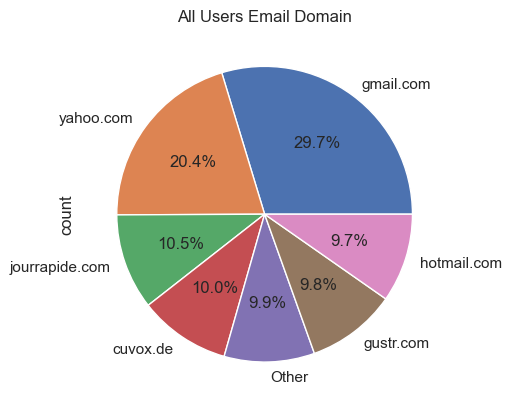 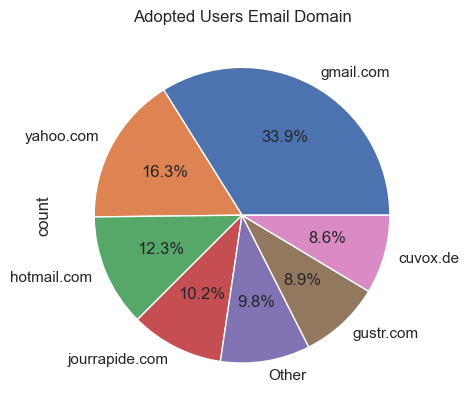 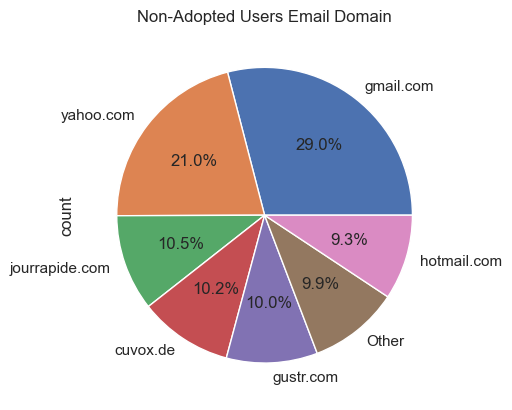


    - **Creation Source:** Through the plots below, it is reasonable to conclude that users that are invited via guest_invite and sign up are more likely to be adopted users. While users who created their account via personal projects and signup_google_auth are more likely to not be adopted users. 

    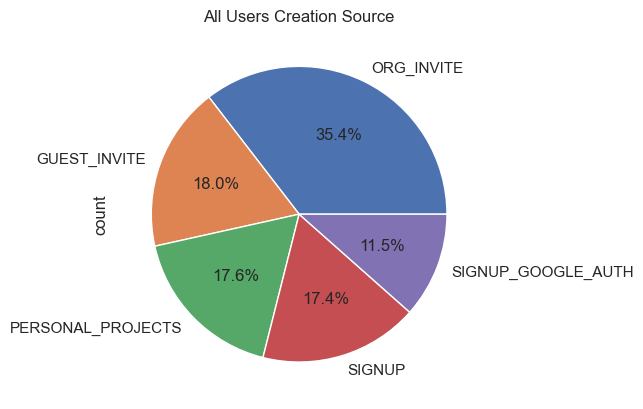 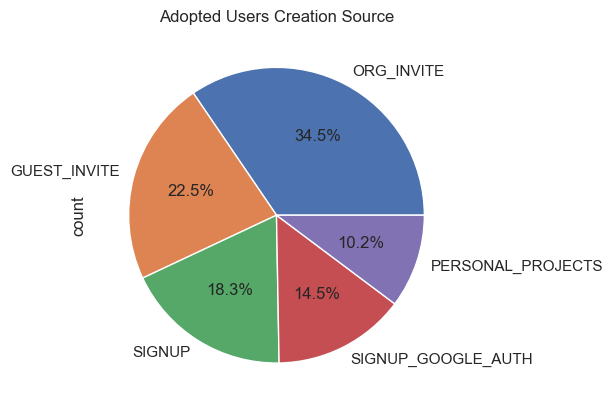 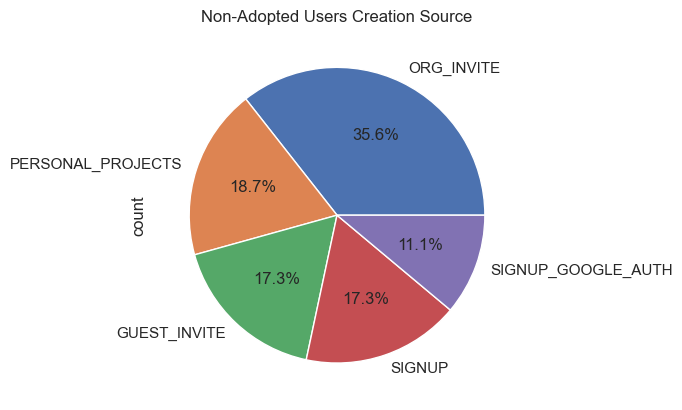

    - **Opted into Mailing List:** By comparing the averages, it is reasonable to conclude that users who have opted into the mailing list are more likely to be adopted users. This could be due to the fact that users who are more engaged with the platform are more likely to opt into the mailing list. This could be a potential feature to include in a model to predict adopted users.

- **Enabled for Marketing Drip:** By comparing the averages, it is reasonable to conclude that users who have enabled the marketing drip are more likely to be adopted users. This could be because users who are more engaged with the product are more likely to enable the marketing drip.

3. **Correlation Analysis:**

    After narrowing down the feature set, I conducted a correlation analysis to understand the relationships between the selected features and user adoption. This analysis helps identify which features are most strongly associated with adoption, providing insights into how different aspects of user behavior and interaction with the product contribute to their likelihood of becoming an adopted user. The closer the correlation value is to 1, the higher the correlation between the two features. The results show a strong positive correlation between user adoption and *org_id*, *creation_source_guest_invite*, *creation_month*, and *email_domain_gmail*. There is also a strong negative correlation (as user adoption increases, the negatively correlated feature decreases) between user adoption and *creation_source_personal_projects* and *creation_year*.

These analyses have narrowed the feature set to *org_id*, *creation_source_guest_invite*, *creation_month*, *email_domain_gmail*, *creation_source_signup_google_auth*, *was_invited*, *email_domain_hotmail.com*, *creation_source_personal_projects*, and *creation_year*. These features will be experimented with in the next section of this notebook.


### 3) What Factors Predict User Adoption?

#### **Data Preprocessing**

As discussed above, the narrowed feature set that will be used in modelling is *org_id*, *creation_source_guest_invite*, *creation_month*, *email_domain_gmail*, *creation_source_signup_google_auth*, *email_domain_hotmail.com*, *creation_source_personal_projects*, and *creation_year*. These features were selected because they are most likely to capture key aspects of user behavior and characteristics that influence adoption.  

In [314]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Features to use in the model
features = [
    'org_id',
    'creation_source_GUEST_INVITE',
    'creation_month',
    'email_domain_eda_gmail.com',
    'creation_source_SIGNUP_GOOGLE_AUTH',
    'was_invited',
    'email_domain_eda_hotmail.com',
    'creation_source_PERSONAL_PROJECTS',
    'creation_year',
    'creation_source_SIGNUP',
    'creation_source_ORG_INVITE',
    'email_domain_eda_yahoo.com',
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip',
    'org_size',
    'last_session_creation_time'
]

# Prepare the feature matrix (X) and target vector (y)
X = users_encoded[features]
y = users_encoded['is_adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### **Model Training**

Experiment with Logistic Regression, Random Forest, and XGBoost

*Logistic Regression*

Accuracy: 0.8650


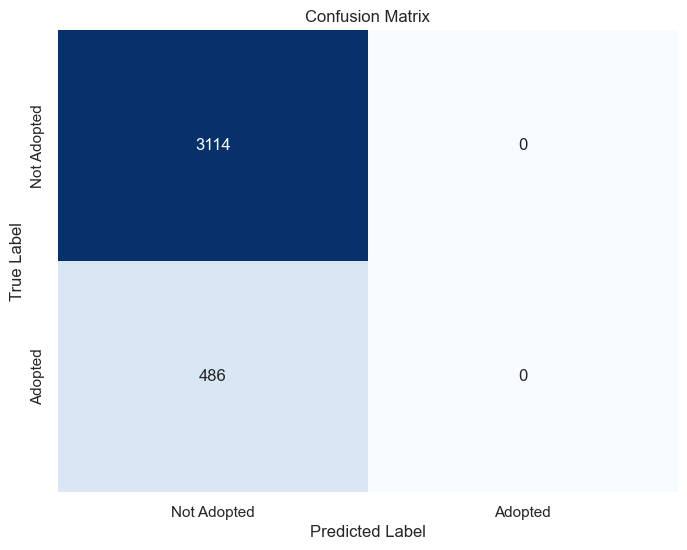

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3114
           1       0.00      0.00      0.00       486

    accuracy                           0.86      3600
   macro avg       0.43      0.50      0.46      3600
weighted avg       0.75      0.86      0.80      3600



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [315]:
# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Not Adopted', 'Adopted'], 
            yticklabels=['Not Adopted', 'Adopted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.9658


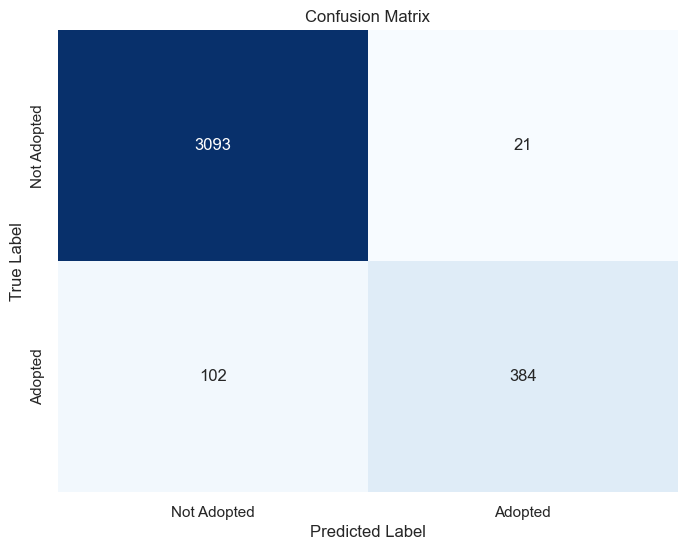

Classification Report:

              precision    recall  f1-score   support

 Not Adopted       0.97      0.99      0.98      3114
     Adopted       0.95      0.79      0.86       486

    accuracy                           0.97      3600
   macro avg       0.96      0.89      0.92      3600
weighted avg       0.97      0.97      0.96      3600



In [316]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Not Adopted', 'Adopted'], 
            yticklabels=['Not Adopted', 'Adopted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Not Adopted', 'Adopted'])
print("Classification Report:\n")
print(class_report)


/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:03:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8519


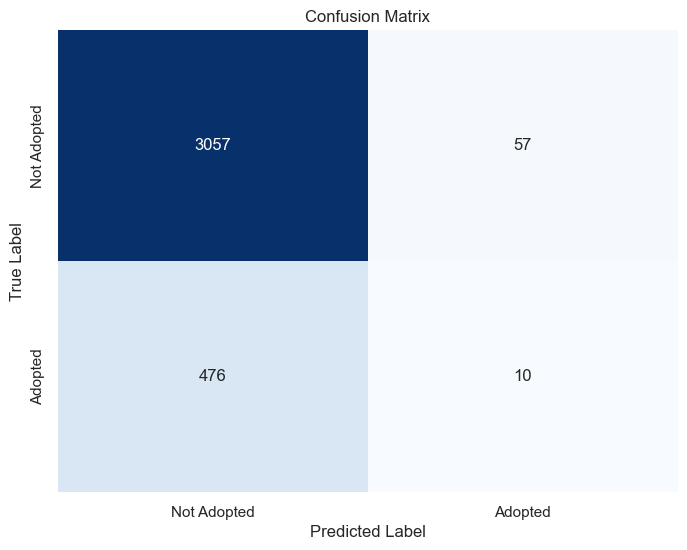

Classification Report:

              precision    recall  f1-score   support

 Not Adopted       0.87      0.98      0.92      3114
     Adopted       0.15      0.02      0.04       486

    accuracy                           0.85      3600
   macro avg       0.51      0.50      0.48      3600
weighted avg       0.77      0.85      0.80      3600



In [313]:
import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Not Adopted', 'Adopted'], 
            yticklabels=['Not Adopted', 'Adopted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['Not Adopted', 'Adopted'])
print("Classification Report:\n")
print(class_report)


#### **Best Performing Model**

The random forest classification model is the best performing model with an accuracy of 96.58%. 

/var/folders/lk/yzt421dn1nq2s0fm1kc8l4rh0000gn/T/ipykernel_15050/1243618116.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


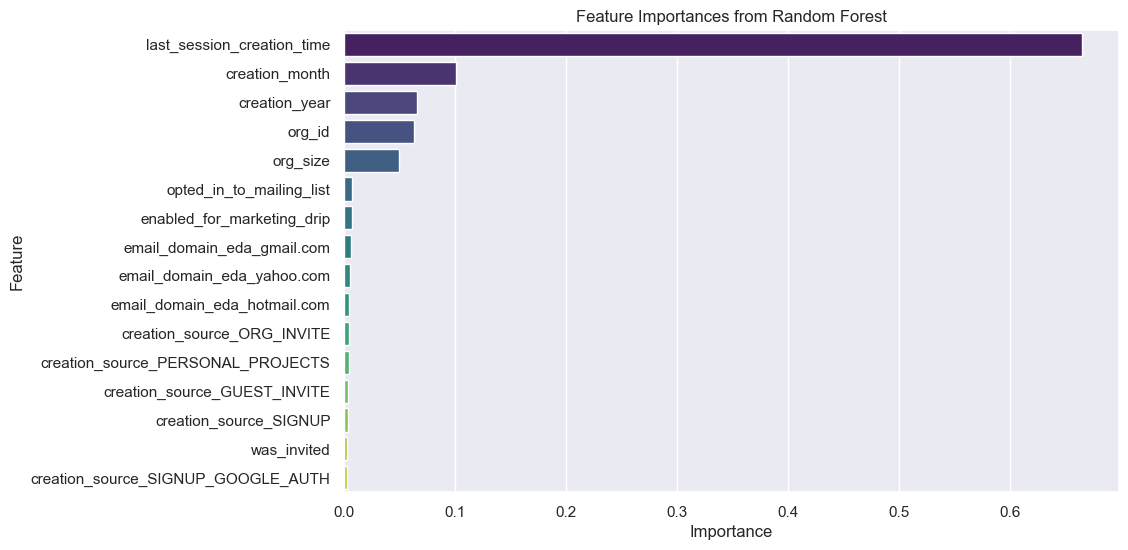

In [317]:
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.show()

##### 3a) Writeup associated with what factors predict user adoption?

After finalizing our feature set, it is time to put it to the test! Three different machine learning models were trained with the same training and test set on the same features all predicting user adoption. Below is a discussion about each model and why it performed the way it did. 

1. Linear regression:

    Logistic regression was chosen for its simplicity and interpretability when it comes to binary clasfficiation problems like the one at hand. However, it is good at capturing linear trends and struggles more with complex/non-linear trends. For the case of adopted users, linear regression was quite poor. Even though it had an accuracy of 86.5% it was only predicting non adoption for every user. This was determined by looking at the confusion matrix which showed that it never predicted adoption user at all. This shows that the trend from feature set to user adoption is non-linear and complex.

2. Random Forest:
    Random Forest was selected for its ability to handle non-linear relationships and interactions between features. It is an ensemble method that builds multiple decision trees and merges them to get more accurate and stable predictions. The model performed better than logistic regression, especially in capturing complex patterns in the data. It had an accuracy of 96.58% where it was correctly identifying the type of user 96.58% of the time! Random forest is an excellent choice for predicting user adoption.

3. XGBoost:
    As a final test, an XGBoost model was trained. XGBoost was included as it is a powerful ensemble method known for its high predictive accuracy and efficiency. It builds trees sequentially, focusing on correcting the errors of the previous trees. However, in the case of user adoption, it struggled to capture the subtle patterns and nuances within the dataset, potentially due to the relatively small size and simplicity of the features. 

Overall, it was found that Random Forest was the strongest model, achieveing an accuracy of 97%. After finalizing the model, the feature importance was analyzed to better understand the strongest indicators for predicting user adoption. 

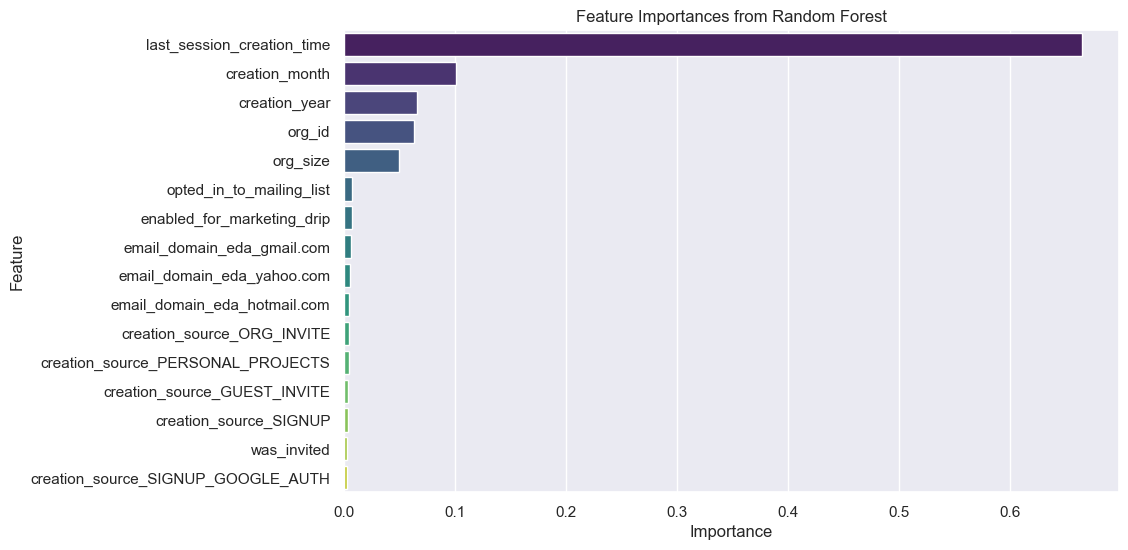

From the image above, it is evident that last session creation time is the most important feature in predicting user adoption. A potential reason for this is that users who log in more recently are more likely to be actively using the product, which is a strong indicator of adoption. Other important features included the year and month the user created the account. A potential reason for the importance could be that older versions were not as devloped/users were not sticking around while newer users are enjoying the platform much more. The last most important indicators had to do with the organization the user was involved in and the size of the organization. Based on the correlation analysis conducted in the previous section, a potential reason for the importance of organization indicators is that smaller organizations may have higher engagement levels, leading to higher adoption rates. This insight suggests that tailoring strategies to support smaller organizations or focusing on onboarding processes for new users could further enhance user adoption.

**Overall, the most important features for predicting user adoption are last_session_creation_time, creation_month, creation_year, org_id, and org_size. When considering ways to increase user adoption, it's crucial to focus on strategies that address these key areas. For instance, ensuring that users are consistently engaged with the product can be critical—this might involve personalized reminders or tailored content to encourage regular logins.**

### 4) Additional Commentary


For future analysis, I would consider going through a more comprehensive feature engineering process, where additional variables such as user engagement metrics, organization-specific behaviors, and interactions with specific product features are explored. 